In [1]:
push!(LOAD_PATH,"../src/")
using UniversalDiffEq

┌ Warning: Error requiring `Enzyme` from `LinearSolve`
│   exception = (LoadError("/Users/johnbuckner/.julia/packages/LinearSolve/qCLK7/ext/LinearSolveEnzymeExt.jl", 1, ArgumentError("Package LinearSolve does not have Enzyme in its dependencies:\n- If you have LinearSolve checked out for development and have\n  added Enzyme as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with LinearSolve")), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000001126ae299, Ptr{Nothing} @0x0000000109296f50, Ptr{Nothing} @0x00000001092cabac, Ptr{Nothing} @0x00000001092c994f, Ptr{Nothing} @0x00000001092ca165, Ptr{Nothing} @0x00000001092c9d72, Ptr{Nothing} @0x00000001092cb045, Ptr{Nothing} @0x0000000113b8ed9a, Ptr{Nothing} @0x0000000109296f50, Ptr{Nothing} @0x0000000113c508b5, Ptr{Nothing} @0x00000001137bebb5, Ptr{Nothing} @0x0000000109296f50, Ptr{Nothing} @0x00000001092a3d3a, Ptr{Nothing} @0x00000001

# Fittting NODEs to data using `UniversalDiffeq.jl`
NODEs are nonparametric time series models that represent changes in the time series with a differntial equaiton where the righ hand side is a neural network
$$
\frac{du}{dt} = NN(u;w,b).
$$
The dynamics of the resulting differntial equation are determined by the weights $w$ and biases $b$ of the neural network, which are found in the training process. 

The `UniversalDiffeq.jl` package is designed with ecologists in mind. Ecologogical data tends to be reletivly sparce and noisy compared to data on physical systems. To accomidate these limitations the training routine used by `UniversalDiffeq.jl` explicitly accounts for observaiton errors. We assume the data $x_t$ is the sum of the true value of the systems state $u_t$ plus a noise term $\epsilon_t$. The training routine jointly estimates the value fo the state variables $u_t$ and the weights $w$ and biases $b$ of the neural network by splitting the loss funciton into to components, and observation loss and a prediction loss. 

The observaiton loss compares the estimated state variables $\hat{u}_t$ to the data$x_t$ using the mean squared error
$$
L_{observation} = \frac{1}{T}\sum_{t=1}^{T}(\hat{u}_t - x_t)^2. 
$$
The process loss compares the model predictions to the estimated state varaibles. The predictions are calcualted by solving the differntial equation over the interval between observations
$$
u_{t+\Delta t} \approx  F(u_t,\Delta t;w,b) = u_t + \int_t^{t+\Delta t} NN(u;w,b)du,
$$
where $F$ is a function representing the soltuon to the differntial equation. The As before the loss is calcualted using the mean squared error 
$$
L_{process} = \frac{1}{T-1}\sum_{t=2}^{T}\left(\hat{u}_t - F(\hat{u}_{t-1},\Delta t; w,b)\right)^2. 
$$
The full loss funcion is the weighted sum of the process and observation losses
$$
L = \omega_{observation}\times L_{observation}+\omega_{process}\times L_{process}.
$$
The default training procedure will give equal weight to the process and observaitonal loss terms. However, if observaiton errors are large increasing the process model weight $\omega_{process}$ can improve performance. Siuilarlly, if the dynamics of the system are highly variable over time, increasing the observation weight $\omega_{observaiton}$ can help incentivise the model to recover these more complex dynamics. 

A regualrization term can also be added to the model to reduce over fitting. Users can choose between $L1$ and $L2$ regualrization terms. These terms add the magnitude of the neural network weights to the loss fucntion weighted by a factor $\omega_{regualrization}$

$$
L = \omega_{observation}\times L_{observation}+\omega_{process}\times L_{process} + \omega_{regularization}||w||_{L_i}.
$$


## Example: Loka Volterra Equaitons

To illustrate the package syntax used we fit a model to the Loka Volterra predator prey model. The package includes a function to simulate a data set from the Loka Volterra model in the correct format. The data is expected to be listed in a data frame with the time of each observation in a colum labeled `t` and the remaining columns contianing the state variables. 

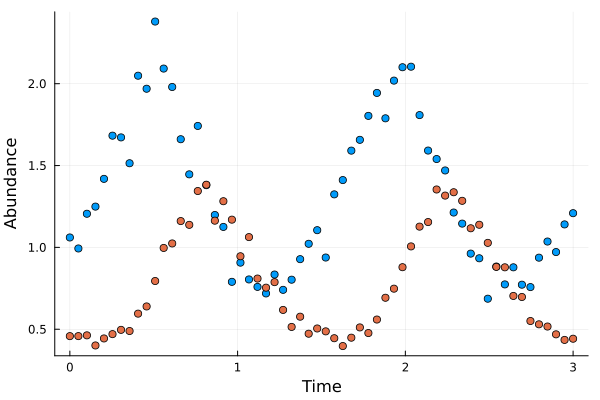

In [2]:
data,plt = LokaVolterra()
plt

In [3]:
Ntest = 20
training_data = data[1:(end - Ntest),:]
test_data = data[(end-Ntest):end,:]
training_data[1:4,:]

Row,t,x1,x2
,Float64,Float32,Float32
1,0.0,1.06062,0.457922
2,0.0508475,0.993459,0.458054
3,0.101695,1.20552,0.462746
4,0.152542,1.24914,0.400984


### Constructing a NODE

Calling the `NODE` function on the data set will generate a NODE model using the default values of all model parameters

In [4]:
model_1 = NODE(training_data)
nothing

Additional customization can be obtained by hanging the values of the key word arguments. These arguments are listed below along with a description of their behaviors and default values.

- hidden_units: Number of neurons in the neural network, larger values increase model complexity (default 10). 
- seed: random number generator seed to initialize the neural network weights (default 1).
- proc_weight: weight given to the process model in the loss function. Larger values produces smoother trajectories of the esitmated state variables $\hat{u}$ (defualt = 1.0). 
- obs_weight: weight given to the process model in the loss function. Larger values cause the estimated state varaibles $\hat{u}$ to more closely match the data $x$ (defualt = 1.0). 
- reg_weight: weight vien to regualrizing the neuarl network. Larger values reduce the flexibility of the model and potential for over fitting (default 10^-6)
- reg_type: Regualrization term "L1" or "L2" (default "L2")
- l: How far the model extapolates beyond the observed data when forecasting as a fration of the data range. Larger values increase how far the extrapolation will go before returning to the default behavior (default 0.25). 
- extrap_rho: The default value of the model when forecasting outside the range of past observations (default = 0.0).

For this dat set I know the dynamics are reletivel smooth so I ahve increased the process weight, decreased the observation weight and increased the regualrization weight. I also expect the model will learn the dynamics of the system reletivel well so I trust that it will extrapolate reasonablly well so I increased the extrapolation length scale parameter to $0.5$.

In [109]:
model_2 = NODE(training_data;hidden_units=20,seed=123,proc_weight=2.0,obs_weight=1.0,reg_weight=10^-3.5,l = 3.0,extrap_rho = 0.25,reg_type = "L2")
nothing

### Fitting the model
The model parameters are trained by calling one of two optimization algorithms `gradient_decent!` or `BFGS`. I have found the best results by starting with `gradient_decent!` and then finishing the optimization with `BFGS`. 

The behavior of the gradient decent algorithm can be controled by changing the `step_size` and `maxiter` key word arguments. Increaseing the `maxiters` and decreasing `step_size` can often improve resutls for difficult to fit data sets. The value of the loss function can be printed after each iteration by setting `verbos` to `true` to track progress. 

In [110]:
gradient_decent!(model_2,step_size = 0.05,maxiter=250,verbos = true)

2.773 2.566 2.369 2.182 2.006 1.841 1.686 1.542 1.408 1.284 1.17 1.065 0.969 0.88 0.799 0.725 0.657 0.595 0.539 0.487 0.44 0.397 0.358 0.323 0.291 0.263 0.237 0.214 0.193 0.175 0.158 0.143 0.13 0.118 0.107 0.097 0.088 0.08 0.072 0.066 0.061 0.056 0.051 0.046 0.042 0.039 0.036 0.034 0.031 0.029 0.027 0.026 0.025 0.024 0.023 0.023 0.022 0.022 0.021 0.021 0.021 0.021 0.021 0.021 0.021 0.021 0.021 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 

In [111]:
BFGS!(model_2,verbos = true)

0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.01

ComponentVector{Float64}(uhat = [1.000386037123227 1.0684353028686493 … 2.001061292979042 2.044116876467541; 0.4817561247798236 0.45438646303778646 … 0.7496073681601756 0.8539806052851235], process_model = (NN = (layer_1 = (weight = [0.262550846085823 -0.5342567012223204; -0.26232041909582327 0.5345103145912071; … ; 0.26218110140972983 -0.5346003531464621; -0.5304056216298952 -0.5861912636442647], bias = [0.0450497046100419; -0.04559693077077257; … ; 0.045873399331759254; 1.4275885637565737;;]), layer_2 = (weight = [0.5468468852463462 -0.5470996290899176 … 0.5471881268584238 0.5827156866424419; 0.2680345619217672 -0.26780459466894846 … 0.2676598824210407 -0.5546307087187332], bias = [-0.4818338173672191; 0.9014673490156269;;]))), process_loss = Float64[], observation_model = Float64[], observation_loss = Float64[], process_regularization = Float64[], observation_regularization = Float64[])

### Checking the model fits 
The package has built in methods for visulaizing the model fits. The `plot_state_estiamtes` function  comares the estimated state varaibles $\hat{u}_t$ to the data $x$. It is best practice to check the fit of the state estimtes before other performance tests, because the models predictions will not be meaningfull if the state estiateates are very poor.

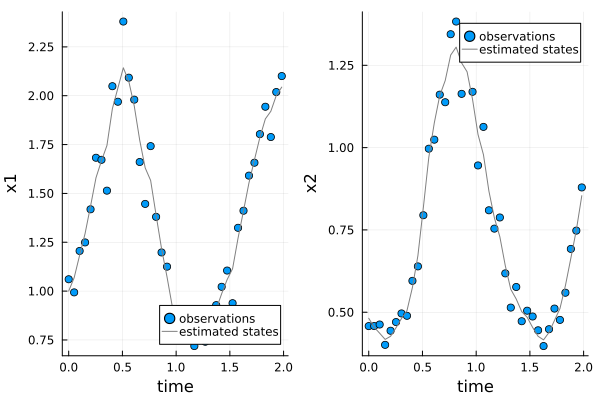

In [96]:
plot_state_estiamtes(model_2)

We can check the in sample model predictions with the `plot_predictions` function. Function compares the cahnge in the state variables predicted to the model to the observed chagnes in the estiamted state varaibales $\hat{u}_t$.

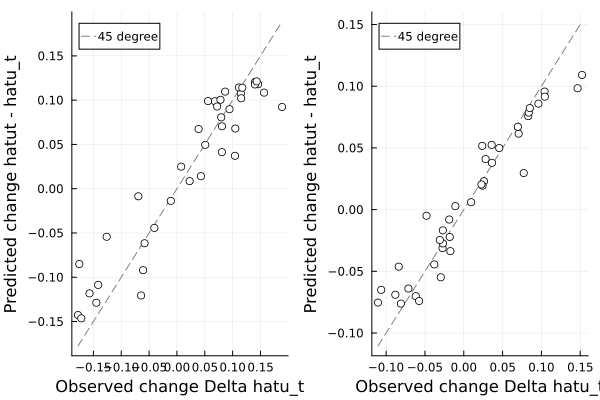

In [9]:
plot_predictions(model_2)

### Testing out of sample performance

Earlier we split the data into a training and testing data set by leaving out the final 15 observaitons. We can compare the the model predictions to the out of sample data using the `plot_forecast` function. This functions starts at the end point of the training data and forecasts the entier length of the test data. It then plots the model forecast to the observed data.

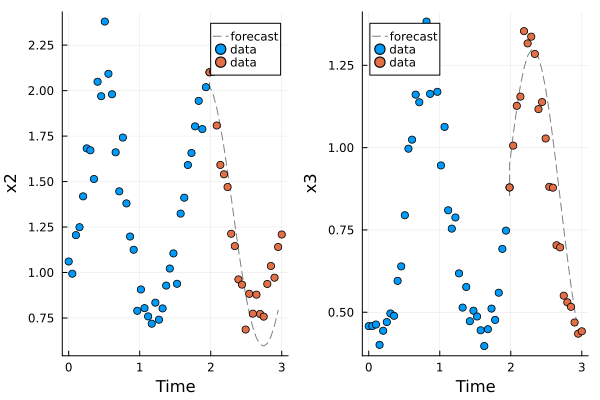

In [10]:
plt,(p1,p2) = UniversalDiffEq.plot_forecast(model_2, test_data)
plt

Predicting many steps into the future may be overly ambitions in many cases. Under these curcumstances we can test the models ability to predict the next data point in the test data by supplying a test data set to the `plot_predictions` function. Note that the prefornace on test data will generally be poor than the training data becasue they include observation errors. 

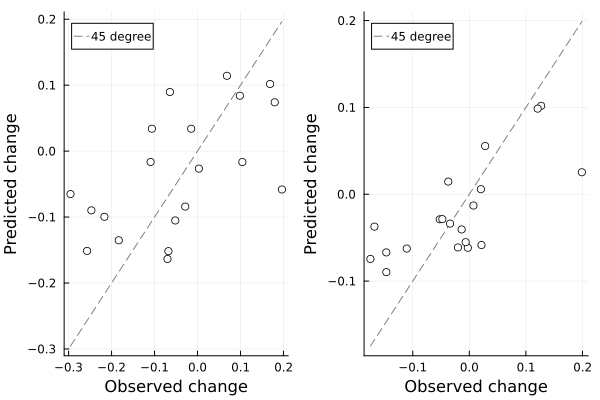

In [11]:
UniversalDiffEq.plot_predictions(model_2, test_data)

### Cross validation

In many cases it may not clear in advance what the best hyper paramters should be used for a given data set or we may wish to compare the perforamce of differnt models on one data set. The package provides code to run leave future out cross validation to systematically test the model's out of sample performance. 

For example, in the followin gcode blocks I compare the performance of a NODEs with and without regualrization on the loka voltera data set using the `leave_future_out_cv`. This function returns a data frame with the mean squared errors of the model predictions for each state varaible and as a function of forecast length. The function also returns time series plots of the forecasts and squared errors. 

The following code block runs the function of the model with regularization:

In [12]:
MSE,(plt1,plt2)=UniversalDiffEq.leave_future_out_cv(model_2; forecast_length = 5, K = 10, spacing = 1, step_size = 0.05, maxiter = 500)
MSE

Row,t,x1,x2
,Float64,Float64,Float64
1,1.0,0.00242344,0.000502936
2,2.0,0.0124283,0.00274894
3,3.0,0.0152227,0.00253752
4,4.0,0.0176825,0.00269286
5,5.0,0.0209746,0.0032359
6,6.0,0.02562,0.00217087


The following cell runs the model test on the default model, that has minimal regularization.

In [13]:
model_1 = UniversalDiffEq.NODE(training_data)
MSE1,(plt1_1,plt2_1)=UniversalDiffEq.leave_future_out_cv(model_1; forecast_length = 5, K = 10, spacing = 1, step_size = 0.05, maxiter = 500)
MSE1

Row,t,x1,x2
,Float64,Float64,Float64
1,1.0,0.00109331,0.000415798
2,2.0,0.0231116,0.00336579
3,3.0,0.0924866,0.00348686
4,4.0,0.273962,0.0110339
5,5.0,0.41859,0.0247025
6,6.0,0.448828,0.0468409


Plotting the results side by side, it is clear that increased regualrization improve the out of sample performance of the NODE in this case.  

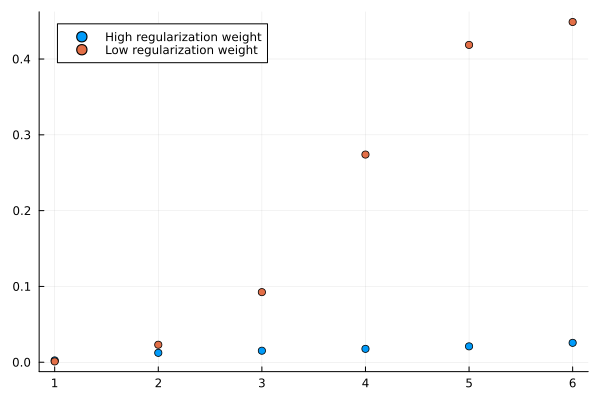

In [14]:
using Plots
Plots.scatter(MSE.t,MSE.x1, label = "High regularization weight")
Plots.scatter!(MSE1.t,MSE1.x1, label = "Low regularization weight")

We can vissualize these differnce using the plots returned by the `leave_future_out_cv` function. In this case the regualrized neural network predicts much less extereme outcomes. 

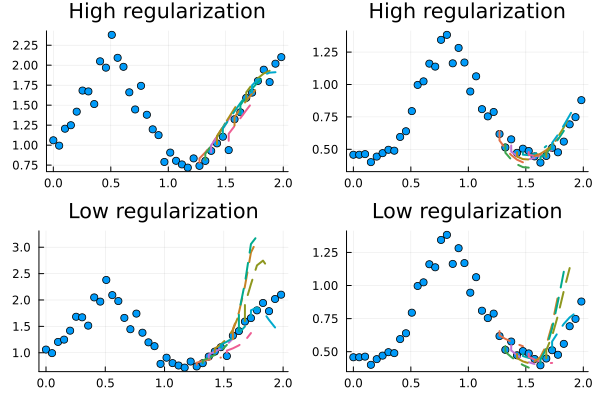

In [15]:
plot(plot!(plt1,title = "High regularization"),plot!(plt1_1,title = "Low regularization"), layout=(2,1))

# Testing forecast with uncertainty 

In [134]:
using Optim, DataFrames

function get_residuals(UDE)
    inits, obs, preds = UniversalDiffEq.predictions(UDE,UDE.data_frame)
    proc_resids = obs.-preds
    link = x -> UDE.observation_model.link(x,UDE.parameters.observation_model)
    obs_resids = mapslices(link,UDE.parameters.uhat,dims=1) .- UDE.data
    return proc_resids, obs_resids
end 

function inverse_link_target(x0,u0,link)
    sum((x0 .- link(u0)).^2)
end 

function invers_link(x0,link)
    target = u ->  inverse_link_target(x0,u,link)
    sol = optimize(target, [0.0, 0.0])
    sol.minimizer
end 

function sample_initial_state(x0,link,obs_resids)
    u0 = invers_link(x0,link)
    u0 .- obs_resids[:,rand(1:size(obs_resids)[2])]
end


function max_(x)
    x[argmax(x)]
end

function min_(x)
    x[argmin(x)]
end

function mean_(x)
    sum(x)/length(x)
end



function forecast(UDE,x0,t0,T,Nsamples)
    uhats = UDE.parameters.uhat
    umax = mapslices(max_, UDE.parameters.uhat, dims = 2);umax=reshape(umax,length(umax))
    umin = mapslices(min_, UDE.parameters.uhat, dims = 2);umin=reshape(umin,length(umin))
    umean = mapslices(mean_, UDE.parameters.uhat, dims = 2);umean=reshape(umean,length(umean))

    dt =sum(UDE.times[2:end] .- UDE.times[1:(end-1)])/length(UDE.times[1:(end-1)])
    estimated_map = (x,t) -> UDE.process_model.forecast(x,t,dt,UDE.parameters.process_model,umax,umin,umean)
    
    proc_resids, obs_resids = get_residuals(UDE)
    link = x -> UDE.observation_model.link(x,UDE.parameters.observation_model)

    # accumulator 
    data = DataFrame(t = zeros(Nsamples*T).+0.01,sample = zeros(Nsamples*T).+0.01)
    for d in 1:length(x0)
        data[:,string("X", d)] .= 0.0
    end 
    j =0
    for i in 1:Nsamples
        u = sample_initial_state(x0,link,obs_resids)
        for t in t0:dt:(dt*(T-1))
            j += 1
            data[j,"t"] = t; data[j,"sample"]=i; data[j,3:end] .= u
            u = estimated_map(u,t)
            u .+= -1* proc_resids[:,rand(1:size(proc_resids)[2])]
        end
    end 
    return data
end 



forecast (generic function with 1 method)

In [142]:
data = forecast(model_2,[0.5,1.0],0.0,40,100)
data[1:4,:]

Row,t,sample,X1,X2
,Float64,Float64,Float64,Float64
1,0.0,1.0,0.518588,1.02579
2,0.0508475,1.0,0.721195,0.914932
3,0.101695,1.0,0.707405,1.04549
4,0.152542,1.0,0.686981,0.939841


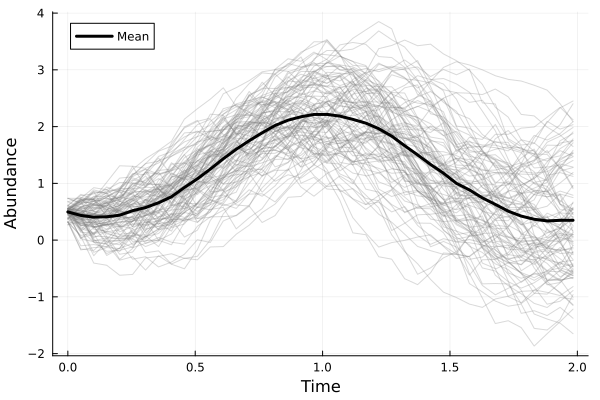

In [145]:
using Chain
mean_data = @chain data begin
    groupby([:t])
    combine(:X1 => x -> sum(x)/length(x),
            :X2 => x -> sum(x)/length(x))
end
Plots.plot(data.t,data.X1,group=string.(data.sample),color="grey" , label ="",alpha = 0.3)
Plots.plot!(mean_data.t,mean_data.X1_function,color="black" , label ="Mean", width = 3,
            xlabel = "Time", ylabel = "Abundance")